In [ ]:
!pip install scikit-image
!pip install pdf2image

In [ ]:
from absl import logging
import os
from pdf2image import convert_from_path
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO

import tensorflow as tf

import tensorflow_hub as hub
from six.moves.urllib.request import urlopen

In [ ]:
delf = hub.load('https://tfhub.dev/google/delf/1').signatures['default']

In [ ]:
def run_delf(image):
  np_image = np.array(image)
  float_image = tf.image.convert_image_dtype(np_image, tf.float32)

  return delf(
      image=float_image,
      score_threshold=tf.constant(100.0),
      image_scales=tf.constant([0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0]),
      max_feature_num=tf.constant(1000))

In [ ]:
def match_images(image1, image2, result1, result2):
  distance_threshold = 0.8

  # Read features.
  num_features_1 = result1['locations'].shape[0]
  print("Loaded image 1's %d features" % num_features_1)
  
  num_features_2 = result2['locations'].shape[0]
  print("Loaded image 2's %d features" % num_features_2)

  # Find nearest-neighbor matches using a KD tree.
  d1_tree = cKDTree(result1['descriptors'])
  _, indices = d1_tree.query(
      result2['descriptors'],
      distance_upper_bound=distance_threshold)

  # Select feature locations for putative matches.
  locations_2_to_use = np.array([
      result2['locations'][i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])

  # Perform geometric verification using RANSAC.
  _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)

  print('Found %d inliers' % sum(inliers))

  # Visualize correspondences.
  _, ax = plt.subplots()
  inlier_idxs = np.nonzero(inliers)[0]
  plot_matches(
      ax,
      image1,
      image2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
  ax.axis('off')
  ax.set_title('DELF correspondences')




In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path = '/content/drive/My Drive/MSK/Dataset/'
path_to_end = '/content/drive/My Drive/MSK/True/'

In [ ]:
os.listdir(path)

['Разр. на ввод', 'Свид. АГР', 'ЗУ', 'Разр. на стр-во', 'БТИ']

In [ ]:
path+os.listdir(path)[1]+'/'+os.listdir(path+os.listdir(path)[0])[0]

'/content/drive/My Drive/MSK/Dataset/Свид. АГР/1.pdf'

In [ ]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.10).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [ ]:
images = convert_from_path(path+os.listdir(path)[4]+'/'+os.listdir(path+os.listdir(path)[4])[2])

In [ ]:
result = run_delf(images[0])
data={}
data['locations'] = result['locations'].numpy().tolist()
data['descriptors'] = result['descriptors'].numpy().tolist()
name_raw = str(os.listdir(path+os.listdir(path)[4])[2])+'.json'


In [ ]:
import json
with open(path_to_end+str(os.listdir(path)[4])+'/'+str(os.listdir(path)[4])+name_raw, 'w') as fp:
  json.dump(data, fp)

ПРОВЕРКА

In [ ]:
def prognoz(path_im_test, name_test, list_f, destfolder, result_path):
    result1 = run_delf(Image.open(path_im_test+name_test))
    inliers_counts = {}
    inliers_counts['name'] = name_test
    inliers_rez = []
    for i in list_f:
        j = i.split('.json')[0]
        with open(destfolder+i, 'r') as fp:
            data = json.load(fp)
        try:
            result = match_images(data, result1)
            #inliers_counts['index'] = j
            #inliers_counts['inliers'] = int(result['inliers'])
            inliers_rez.append({"index": j, "inliers": int(result['inliers'])})
        except:
            pass
    top_match = sorted(inliers_rez, key=lambda k: k['inliers'], reverse=True)[0]
    inliers_counts['index'] = top_match['index']
    inliers_counts['inliers'] = top_match['inliers']
    with open(result_path+name_test.split('.jpg')[0]+'.json', 'w') as fp:
        json.dump(inliers_counts, fp)

In [ ]:
def match_images(data, result2):
    distance_threshold = 0.6#0.8

    num_features_1 = len(data['locations'])
    num_features_2 = result2['locations'].shape[0]

    d1_tree = cKDTree(data['descriptors'])
    _, indices = d1_tree.query(
        result2['descriptors'],
        distance_upper_bound=distance_threshold)

    locations_2_to_use = np.array([
        result2['locations'][i,]
        for i in range(num_features_2)
        if indices[i] != num_features_1
    ])
    locations_1_to_use = np.array([
        data['locations'][indices[i]]
        for i in range(num_features_2)
        if indices[i] != num_features_1
    ])

    _, inliers = ransac(
        (locations_1_to_use, locations_2_to_use),
        AffineTransform,
        min_samples=3,#10 - 0:04:48.434188#4 - 12 мин #3 - 12 мин, 2 - 15 мин
        residual_threshold=20,
        max_trials=1000)#1000
    return {"inliers": sum(inliers)}

In [ ]:
list_test = os.listdir(path+os.listdir(path)[0])

In [ ]:
import json
for test in list_test:
  with open((path_to_end+str(os.listdir(path)[0])+'/'+'1.pdf.json'), 'r') as fp:
    data = json.load(fp)
  images = convert_from_path(path+os.listdir(path)[0]+'/'+test)
  result = run_delf(images[0])
  try:
    inliers_counts = {}
    inliers_counts['name'] = test
    inliers_rez = []
    result = match_images(data, result)
    inliers_rez.append({"inliers": int(result['inliers'])})
  except:
    pass
  print (inliers_counts)


{'name': '1.pdf'}
{'name': '11.pdf'}
{'name': '10.pdf'}
{'name': '13.pdf'}
{'name': '12.pdf'}
{'name': '14.pdf'}
{'name': '15.pdf'}
{'name': '16.pdf'}
{'name': '18.pdf'}
{'name': '17.pdf'}
{'name': '2.pdf'}
{'name': '21.pdf'}
{'name': '19.pdf'}
{'name': '20.pdf'}
{'name': '22.pdf'}
{'name': '29.pdf'}
{'name': '23.pdf'}
{'name': '27.pdf'}
{'name': '28.pdf'}
{'name': '26.pdf'}
{'name': '25.pdf'}
{'name': '3.pdf'}
{'name': '24.pdf'}
{'name': '33.pdf'}
{'name': '32.pdf'}
{'name': '34.pdf'}
{'name': '30.pdf'}
{'name': '31.pdf'}
{'name': '37.pdf'}
{'name': '40.pdf'}
{'name': '36.pdf'}
{'name': '39.pdf'}
{'name': '4.pdf'}
{'name': '38.pdf'}
{'name': '41.pdf'}
{'name': '35.pdf'}
{'name': '42.pdf'}
{'name': '45.pdf'}
{'name': '47.pdf'}
{'name': '49.pdf'}
{'name': '44.pdf'}
{'name': '5.pdf'}
{'name': '46.pdf'}
{'name': '43.pdf'}
{'name': '48.pdf'}
{'name': '53.pdf'}
{'name': '54.pdf'}
{'name': '56.pdf'}
{'name': '51.pdf'}
{'name': '52.pdf'}
{'name': '55.pdf'}
{'name': '61.pdf'}
{'name': '59.pdf'

In [ ]:
inliers_counts

In [ ]:
for test in list_test:
    print (test)
    try:
        prognoz(path_im_test, test, list_f, destfolder, result_path)
    except:
        lm = {}
        lm['name'] = test
        with open(result_path_false+test.split('.jpg')[0]+'.json', 'w') as fp:
            json.dump(lm, fp)

In [ ]:
image1='/content/drive/My Drive/MSK/11.jpg'
image2='/content/drive/My Drive/MSK/10_Страница_1.jpg'
image3='/content/drive/My Drive/MSK/1_Страница_1.jpg'
image4='/content/drive/My Drive/MSK/4_Страница_1.jpg'

In [ ]:
def download_and_resize(name, new_width=256, new_height=256):
  image = Image.open(name)
  image = ImageOps.fit(image, (new_width, new_height), Image.ANTIALIAS)
  image = image.convert('RGB')
  #pil_image_rgb.save(filename, format='JPEG', quality=90)
  return image

In [ ]:
a = download_and_resize(image1)
b = download_and_resize(image2)
c = download_and_resize(image3)
d = download_and_resize(image4)

In [ ]:
result1 = run_delf(a)
result2 = run_delf(b)
result3 = run_delf(c)
result4 = run_delf(d)

Loaded image 1's 16 features
Loaded image 2's 16 features
Found 12 inliers


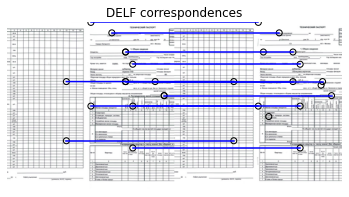

In [ ]:
match_images(a, b, result1, result2)

In [ ]:
match_images(a, c, result1, result3)

Loaded image 1's 16 features
Loaded image 2's 11 features


ValueError: ignored

In [ ]:
match_images(a, d, result1, result4)

Loaded image 1's 16 features
Loaded image 2's 11 features


ValueError: ignored

Loaded image 1's 11 features
Loaded image 2's 11 features
Found 4 inliers


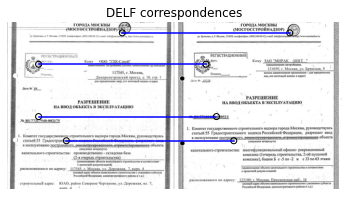

In [ ]:
match_images(c, d, result3, result4)